In [18]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from StrongFieldIonizer import StrongFieldIonizer, write_sfi_results, load_sfi_results
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm

In [19]:
# setup simulation and k-space
sim = StrongFieldIonizer()
sim.epsilon = 1
sim.t_start = 0.0
sim.t_end   = sim.T
sim.N_time  = 1000
sim.Nc = 1

#sim.user_envelope = lambda t : 1

Up = sim.Up
threshold = 3.0 * np.sqrt(Up)
k_range = [ -threshold, threshold ]
N_ks    = 300

k_ys, k_zs = sim.get_k_space(k_range, N_ks)
Z, Y = np.meshgrid(k_ys, k_zs)

# sweep of values
factor = 3.51e16
intensity_values = np.logspace(12, 14.5, 20) / factor

all_A_ts = []
all_matrices = []

# run simulations
for intensity in tqdm(intensity_values) : 
    sim.intensity = intensity
    A_ts, _, _, matrix = sim.calculate_matrix_elements(k_range=k_range, N_ks=N_ks, progress_bar=False)

    all_A_ts.append(A_ts)
    all_matrices.append(matrix)
    

100%|██████████| 20/20 [04:19<00:00, 12.96s/it]


In [20]:
write_sfi_results(outfname="./Animations/sfi_results_nc_intensity_circular.txt.gz", simulator=sim, k_range=k_range, N_ks=N_ks, parameters=intensity_values, all_A_ts=all_A_ts, all_matrices=all_matrices)

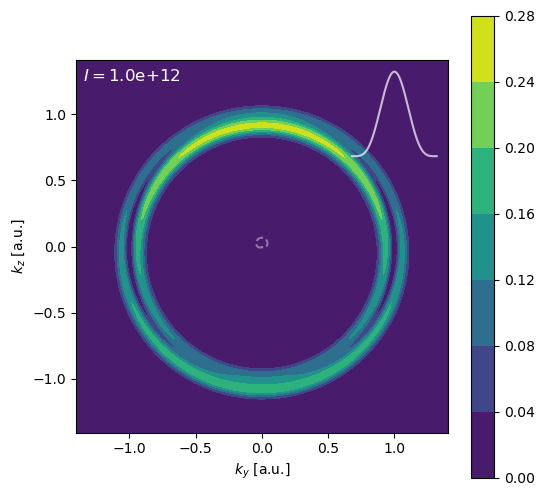

In [22]:
fig = plt.figure(figsize=(6,6))

circle = lambda n : np.sqrt(2*( sim.E0 - sim.Up + n * sim.wl ))


def update(i):
    # clear the whole figure
    fig.clear()

    # retrieve simulation results
    A_ts = all_A_ts[i]
    A_ys, A_zs = -A_ts[1], -A_ts[2]
    A2 = np.sum(A_ts**2, axis=0)
    matrix = all_matrices[i]

    # do all the plotting
    ax = fig.add_subplot(1,1,1)

    cf = ax.contourf(Y, Z, matrix)
    ax.plot(A_ys, A_zs, 'w--', alpha=0.4)

    #ns = [17, 18, 19]
    #n_string = '$N =$'
    #for n in ns : 
    #    c = plt.Circle((0.0, 0.0), circle(n), color='tab:red', fill=False, alpha=0.5)
    #    n_string += f' {n}'
    #    if n is not ns[-1] : n_string += ','
    #    ax.add_patch(c)

    ax.set_xlabel("$k_y$ [a.u.]")
    ax.set_ylabel("$k_z$ [a.u.]")
    ax.set_aspect('equal')

    fig.colorbar(cf, ax=ax)

    # text label
    ax.text(
        0.02, 0.98,               
        rf"$I = ${float(intensity_values[i])*factor:.1e}",
        transform=ax.transAxes,    
        color='white',             
        va='top', ha='left',       
        fontsize=12                
    )

    # text label
    #ax.text(
    #    0.02, 0.06,               
    #    n_string,
    #    transform=ax.transAxes,    
    #    color='white',             
    #    va='top', ha='left',       
    #    fontsize=12                
    #)

    # make inset plot
    iax = inset_axes(ax, width="25%", height="25%", loc='upper right', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes)
    # plot envelope profile
    iax.plot(np.arange(len(A2)), A2, color='white', alpha=0.7)
    # make transparent
    iax.set_facecolor((0,0,0,0))
    # remove borders
    for spine in iax.spines.values(): spine.set_visible(False)
    # remove ticks
    iax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


ani = FuncAnimation(fig, update,
                    frames=len(intensity_values),
                    interval=800,   # ms between frames
                    blit=False)

writer = PillowWriter(fps=2)
ani.save("./Animations/sfi_sweep_intensity_circular.gif", writer=writer)